In [1]:
import pandas as pd
import plotly.express as px

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [3]:
city = df_train.loc[df_train['City'] == 'Atlanta']
intersections = city['IntersectionId'].unique()

Get mean intersection wait times in the 80th percentile

In [9]:
longs = []
lats = []
mean_80_wait = []
for inter in intersections:
    intersection = city.loc[city['IntersectionId'] == inter]
    longs.append(intersection['Longitude'].values[0])
    lats.append(intersection['Latitude'].values[0])
    mean_80_wait.append(intersection['TotalTimeStopped_p80'].values.mean())
df = pd.DataFrame(list(zip(longs, lats,mean_80_wait,intersections)),
               columns =['lon', 'lat','wait','intid'])

In [10]:
fig = px.scatter_mapbox(df, lat="lat", lon="lon",
                        color_discrete_sequence=["black"],size=mean_80_wait, zoom=10, height=400,hover_data=['intid'])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

---

In [1]:
import os
import pandas as pd
import datetime as dt
import numpy as np
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

df_train = df_train.fillna('ffill')
df_test = df_test.fillna('ffill')

In [3]:
# separate labels from features
full_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p40','TotalTimeStopped_p50',
                       'TotalTimeStopped_p60','TotalTimeStopped_p80',
                       'TimeFromFirstStop_p20','TimeFromFirstStop_p40','TimeFromFirstStop_p50',
                       'TimeFromFirstStop_p60','TimeFromFirstStop_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p40','DistanceToFirstStop_p50',
                       'DistanceToFirstStop_p60','DistanceToFirstStop_p80']
rel_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']


df_train_y = df_train[rel_training_label_cols]

# drop columns not needed
df_test_X = df_test.drop(columns=['RowId'])
df_train_X = df_train.drop(columns=['RowId']+full_training_label_cols)

In [4]:
cities = ['Atlanta','Philadelphia','Boston','Chicago']
city_training_datasets_X = {}
city_training_datasets_y = {}
city_testing_datasets_X = {}

# training
for city in cities:
    # get rows for this city
    city_idxs = (df_train_X['City'] == city).values.nonzero()[0]

    # get X (data) and y (labels)
    city_training_datasets_X[city] = df_train_X.loc[city_idxs]
    city_training_datasets_y[city] = df_train_y.loc[city_idxs]

    # drop the city column from X (data)
    city_training_datasets_X[city] = city_training_datasets_X[city].drop(columns=['City'])

# testing
for city in cities:
    # get rows for this city
    city_idxs = (df_test_X['City'] == city).values.nonzero()[0]

    # get X (data)
    city_testing_datasets_X[city] = df_test_X.loc[city_idxs]

    # drop the city column from X (data)
    city_testing_datasets_X[city] = city_testing_datasets_X[city].drop(columns=['City'])

In [10]:
centers = np.array([[-84.48949368,  33.77535102],
       [-84.38952255,  33.7554171 ],
       [-84.40632977,  33.79067253],
       [-84.36584325,  33.81838591],
       [-84.45318313,  33.68059744],
       [-84.34380495,  33.7611558 ]])

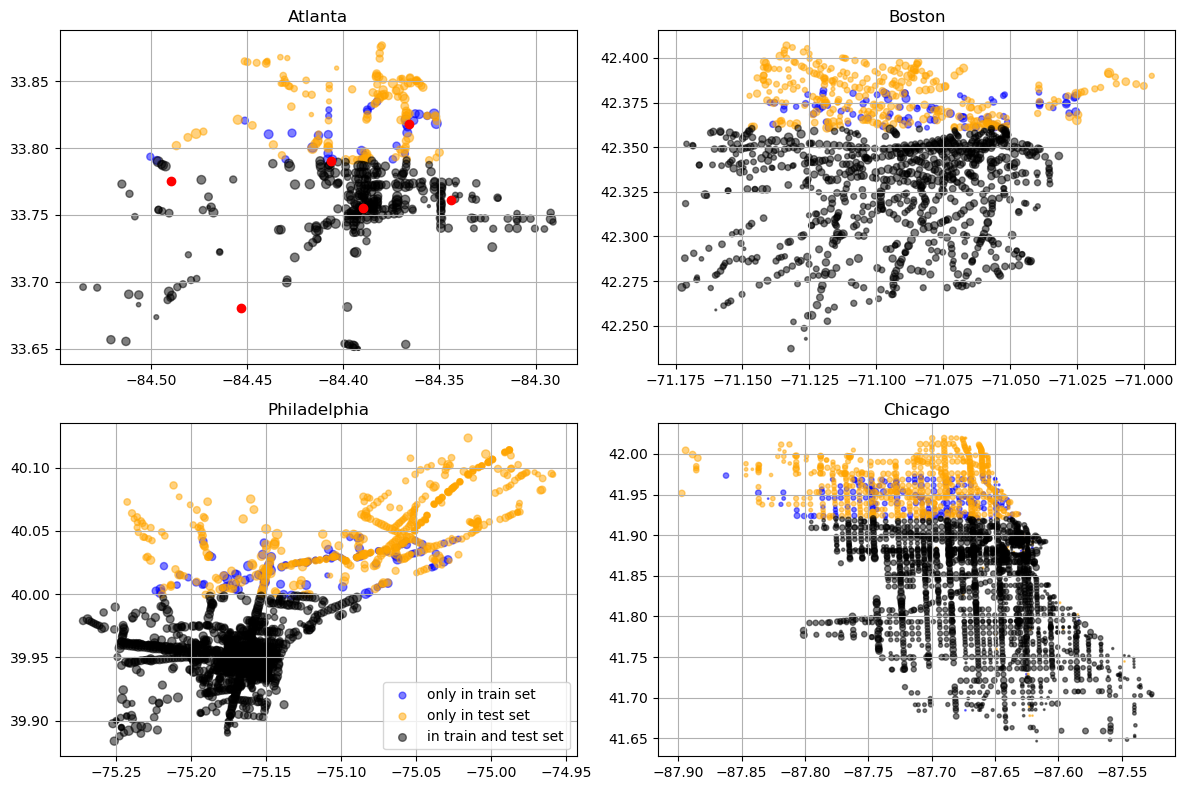

In [11]:
fig,ax = plt.subplots(2,2,figsize=(12,8))

for city_i,city in enumerate(cities):
    # get the train and test labeled
    train_points = city_training_datasets_X[city]
    train_points['train'] = 1
    test_points = city_testing_datasets_X[city]
    test_points['test'] = 0
    total = pd.concat([train_points,test_points])

    # get counts per intersection
    counts_per_intersection = total.groupby('IntersectionId').size().reset_index()

    # group by intersection id
    grouped_train = city_training_datasets_X[city].groupby('IntersectionId').agg({'Longitude': 'first', 'Latitude': 'first'}).reset_index()
    grouped_test = city_testing_datasets_X[city].groupby('IntersectionId').agg({'Longitude': 'first', 'Latitude': 'first'}).reset_index()
    grouped_all = total.groupby('IntersectionId').agg({'Longitude': 'first', 'Latitude': 'first'}).reset_index()
    
    # get intersections that are only train
    unique_train_intersection_ids = np.setdiff1d(np.unique(train_points['IntersectionId'].values),np.unique(test_points['IntersectionId'].values))
    unique_train_intersections = grouped_train[grouped_train['IntersectionId'].isin(unique_train_intersection_ids)]
    unique_train_intersection_sizes = counts_per_intersection[counts_per_intersection['IntersectionId'].isin(unique_train_intersection_ids)].values[:,1]

    # get intersections that are only test
    unique_test_intersection_ids = np.setdiff1d(np.unique(test_points['IntersectionId'].values),np.unique(train_points['IntersectionId'].values))
    unique_test_intersections = grouped_test[grouped_test['IntersectionId'].isin(unique_test_intersection_ids)]
    unique_test_intersection_sizes = counts_per_intersection[counts_per_intersection['IntersectionId'].isin(unique_test_intersection_ids)].values[:,1]

    # get intersections that appear in both
    unique_intersection_ids = np.concatenate([unique_test_intersection_ids,unique_train_intersection_ids])
    nonunique_intersection_ids = np.setdiff1d(np.unique(total['IntersectionId']),unique_intersection_ids)
    nonunique_intersections = grouped_all[grouped_all['IntersectionId'].isin(nonunique_intersection_ids)]
    nonunique_intersection_sizes = counts_per_intersection[counts_per_intersection['IntersectionId'].isin(nonunique_intersection_ids)].values[:,1]

    # print(unique_train_intersection_sizes.sum())
    # print(unique_test_intersection_sizes.sum())
    # print(nonunique_intersection_sizes.sum())
    # print()

    row = city_i % 2
    col = city_i // 2
    ax[row][col].scatter(unique_train_intersections['Longitude'],unique_train_intersections['Latitude'],c='blue',s=np.sqrt(unique_train_intersection_sizes),
                         alpha=0.5,label='only in train set')
    ax[row][col].scatter(unique_test_intersections['Longitude'],unique_test_intersections['Latitude'],c='orange',s=np.sqrt(unique_test_intersection_sizes),
                         alpha=0.5,label='only in test set')
    ax[row][col].scatter(nonunique_intersections['Longitude'],nonunique_intersections['Latitude'],c='k',s=np.sqrt(nonunique_intersection_sizes),
                         alpha=0.5,label='in train and test set')
    ax[row][col].set_title(city)
    ax[row][col].grid()
ax[1][0].legend()
ax[0][0].scatter(centers[:,0],centers[:,1],c='r')
plt.tight_layout()
fig.savefig('visualize.png')

In [131]:
unique_train_intersection_sizes

array([167, 288,   8,   1, 104,  65,  49, 139, 142, 109, 255, 202,  44,
         4,  95, 177, 181, 114, 131, 281, 124,  68, 122, 130, 362,  39,
        36, 230,   1, 420, 140, 164, 130, 113, 193, 163,   9, 152,  65,
        72, 338, 221, 346, 217,   1, 173, 294, 250,  39, 101, 207,   2,
         1, 176,  32, 135, 188,  77,  24,   3, 141, 224, 296,  17, 170,
       367, 231, 319,   1,   1, 271, 107, 120, 227, 541, 156, 204, 149,
        30, 351, 279, 292, 145, 299,  84, 144, 375, 153, 110, 215,  69,
       109, 202, 178, 103, 108, 181,  33,  82, 202, 239, 410, 161,   4,
         1, 209, 235,  68, 174, 135, 181,   2, 197, 160, 126, 158, 153,
       222,  68, 358,   2, 424, 198, 217, 242, 125, 218, 297,  69, 186,
       213, 155,  74,   1, 139, 158, 297,   6,  30, 282, 200, 130,  42,
       124, 278,  61, 103,  20, 259,  21,  78,  79, 465,  28, 160, 131,
       124, 209, 177,  79, 178, 110,  39,  78, 196, 128, 161, 400, 197,
       277,   6,  14,  75, 132, 205,   9, 172,   1,  45, 598, 11